 # Software Project : Tchernobyl test zone :

- conda create -n software python=3.11.5
- conda activate software
- pip install ipykernel #VS code kernel library
- pip install pandas
- pip install tqdm
- pip install matplotlib
- pip install seaborn
- pip install lxml

## 1.0°/ Initialization :

In [2]:
# Base import
from datetime import datetime
import pandas as pd
import numpy as np

# Webo scrappo
#import requests
#import urllib.request
#from bs4 import BeautifulSoup

# Data visualization
import matplotlib.pyplot as plt
#import seaborn as sns

# Set up path between folder to call our functions
import sys
sys.path.append('.')
sys.path.append('./src')

# Code aesthetic
#import tqdm
import warnings

warnings.filterwarnings('ignore')

In [3]:
start_year = 1980 #1947 début BBA, 1950 début NBA, à partir de 1980 on a plus de colonnes
end_year = datetime.today().year
years = []
for i in range(start_year, end_year+1):
    years.append(i)

str = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'


# We can make use our app to make comparison through the years
for i in years:
    url = str.format(i)
    print(url)

https://www.basketball-reference.com/leagues/NBA_1980_per_game.html
https://www.basketball-reference.com/leagues/NBA_1981_per_game.html
https://www.basketball-reference.com/leagues/NBA_1982_per_game.html
https://www.basketball-reference.com/leagues/NBA_1983_per_game.html
https://www.basketball-reference.com/leagues/NBA_1984_per_game.html
https://www.basketball-reference.com/leagues/NBA_1985_per_game.html
https://www.basketball-reference.com/leagues/NBA_1986_per_game.html
https://www.basketball-reference.com/leagues/NBA_1987_per_game.html
https://www.basketball-reference.com/leagues/NBA_1988_per_game.html
https://www.basketball-reference.com/leagues/NBA_1989_per_game.html
https://www.basketball-reference.com/leagues/NBA_1990_per_game.html
https://www.basketball-reference.com/leagues/NBA_1991_per_game.html
https://www.basketball-reference.com/leagues/NBA_1992_per_game.html
https://www.basketball-reference.com/leagues/NBA_1993_per_game.html
https://www.basketball-reference.com/leagues/NBA

In [4]:
url = str.format(years[-2])

df = pd.read_html(url, header = 0)[0]
df['Year'] = years[-2]

# This request output a list of dataframe read from the url, let's select the correct one :
# r[0] => Regular Season /// r[1] => playoffs
#df = r[0]
df.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
0,1.0,Joel Embiid,29.0,PHI,C,39.0,39.0,33.6,11.5,21.8,...,8.6,11.0,5.6,1.2,1.7,3.8,2.9,34.7,AS,2024
1,2.0,Luka Dončić,24.0,DAL,PG,70.0,70.0,37.5,11.5,23.6,...,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9,"MVP-3,CPOY-6,AS,NBA1",2024
2,3.0,Giannis Antetokounmpo,29.0,MIL,PF,73.0,73.0,35.2,11.5,18.8,...,8.8,11.5,6.5,1.2,1.1,3.4,2.9,30.4,"MVP-4,DPOY-9,CPOY-12,AS,NBA1",2024
3,4.0,Shai Gilgeous-Alexander,25.0,OKC,PG,75.0,75.0,34.0,10.6,19.8,...,4.7,5.5,6.2,2.0,0.9,2.2,2.5,30.1,"MVP-2,DPOY-7,CPOY-3,AS,NBA1",2024
4,5.0,Jalen Brunson,27.0,NYK,PG,77.0,77.0,35.4,10.3,21.4,...,3.1,3.6,6.7,0.9,0.2,2.4,1.9,28.7,"MVP-5,CPOY-5,AS,NBA2",2024


## 2.0°/ Cleaning :

### 2.1°/ Small cleaning :

In [5]:
#===================================================
#== Problems specific to a unique row or column : ==
#===================================================

# The last rows contains average of all players => useless
# df.loc[df['Rk'].isna()] => return an empty row
df = df.drop(df.tail(1).index)

# The columns G and GS are float, even though all number are int
# df.dtypes
try:
    df['G'] = df['G'].astype('int32')
    df['GS'] = df['GS'].astype('int32')
    print("toutes les colonnes ont été converties.")
except KeyError:
    print("certaines colonnes n'existent pas, le reste a été converti.")

toutes les colonnes ont été converties.


### 2.2°/ Missing values :

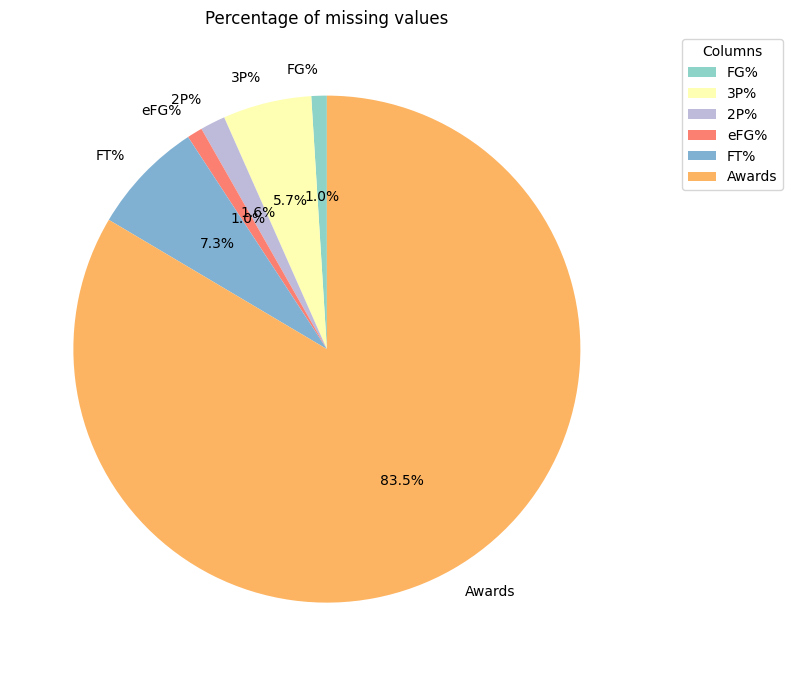

In [6]:
#=======================================================
#== Find the NaN value throughout our df ==
#=======================================================

# Most missing value come from the fact that some players switched teams during the season
missing = df.isna().sum()

missing = missing[missing > 0]

colors = plt.cm.Set3.colors

plt.figure(figsize=(8, 8))
plt.pie(
    missing,
    labels=missing.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(missing)]
)

plt.title("Percentage of missing values")
plt.legend(
    missing.index,
    title="Columns",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

In [7]:
# Truth be told, the NaN
# So let's just set them up to 0, the ranking argument is the points scored 'PTS', so it shouldn't be a problem for our futur uses. 
# missing.index => ctrl + c & ctrl + v
# df[['FG%', '3P%', '2P%', 'eFG%', 'FT%']] = df[['FG%', '3P%', '2P%', 'eFG%', 'FT%']].fillna(0.0)
# that's what we would have done if we didn't read the data, but anyways the only missing % is when it's equal to 0.0 so it's also working in theory

#for some other years, others informations are missing, there is the filling part for every possible blank
def calc_percentage (numerator:str,denominator:str):
    return df[numerator]/df[denominator].round(3)

transfo = {
    'FG%': calc_percentage("FG","FGA").fillna(0), #on fillna car pandas laisse du na quand tu fais une division impossible et il te préviens pas cet enculé histoire que tu perde 1h30 dessus
    '3P%': calc_percentage("3P","3PA").fillna(0), #du coup ça rempli d'abord tout ce que ça peut remplir et après ça met des 0 quand le calcul était pas possible (divison par 0)
    '2P%': calc_percentage("2P","2PA").fillna(0),
    'FT%': calc_percentage("FT","FTA").fillna(0),
    'Awards': 'No Awards'
    }

for key,values in transfo.items():
    try:
        df[key] = df[key].fillna(values)
        print(f"La colonne {key} a été remplie avec succès.")
    except KeyError:
        print(f"La colonne {key} n'existe pas sur cette année là.")

#special treatment for eFG%:
df['eFG%'] = round(((df['PTS']-df['FT'])/2)/df['FGA'],3).fillna(0) #bc i cannot find how the calcul was made on the website so i use mine

La colonne FG% a été remplie avec succès.
La colonne 3P% a été remplie avec succès.
La colonne 2P% a été remplie avec succès.
La colonne FT% a été remplie avec succès.
La colonne Awards a été remplie avec succès.


In [28]:
#for k, v in list(zip(df.dtypes.index, df.dtypes)):
#    print(f"'{k}' : '{v}',")

### 2.3°/ Player switching team problem : ON S'EN BRANLE DU COUP A PARTIR D'ICI!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Some of the players played on 2/3+ differents teams during the season, meaning they got 3 rows (with the same rank though) (one for each team and another who concatenate the informations labelled "XTM" with X the number of team he joined). 


But for most of them they end up with almost no games played on their new teams, meaning empty value.
To fill these empty rows, some options appears before us :
- Drop the "teams column" and averaging their score while keeping the coefficient by "game played.
- Keep the "teams column" but keep only their most played team score and enhance them with their other team score (so that the rank can be justified).
- Keep the "teams column" but drop their less played team score, could lead to problem with their global ranking.

In [9]:
duplicate = df[df.duplicated(subset=['Rk', 'Player'], keep=False)]
nb_duplicate_rows = duplicate.shape[0]
nb_player_duplicate = duplicate['Player'].nunique()

print(f"Number of duplicate rows : {nb_duplicate_rows}.\nNumber of of player that switched teams : {nb_player_duplicate}.")

Number of duplicate rows : 241.
Number of of player that switched teams : 78.


In [10]:
# Get df columns and copy past
#df.columns
# Need to be used as key when GROUP BY
id_col = ['Rk', 'Player', 'Age']
# Need to find the category he played the most
categorical_col = ['Team', 'Pos', 'Awards']
# Need to SUM these columns when GROUP BY
int_col = ['G', 'GS']
# Need to AVG these columns by game played when GROUP BY
float_col = ['MP', 'FG', 'FGA','FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [11]:
def weighted_avg(series, weights):
    return np.average(series, weights=weights)

def most_games_category(df, col):
    return df.loc[df['G'].idxmax(), col]

In [12]:
agg_dict = {}

# Sum integer columns
for col in int_col:
    agg_dict[col] = 'sum'

# Weighted average float columns
for col in float_col:
    agg_dict[col] = lambda x, c=col: weighted_avg(x, df.loc[x.index, 'G'])
    

df_grouped = (
    df
    .groupby(id_col, as_index=False)
    .agg(agg_dict)
)

for col in categorical_col:
    df_grouped[col] = (
        df
        .groupby(id_col)
        .apply(lambda x: most_games_category(x, col))
        .values
    )

final_cols = id_col + categorical_col + int_col + float_col
df_grouped = df_grouped[final_cols]


In [13]:
agg_dict = {}

# Sum integer columns
for col in int_col:
    agg_dict[col] = 'sum'

# Weighted average float columns
for col in float_col:
    agg_dict[col] = lambda x, c=col: weighted_avg(x, df.loc[x.index, 'G'])

In [14]:
agg_dict

{'G': 'sum',
 'GS': 'sum',
 'MP': <function __main__.<lambda>(x, c='MP')>,
 'FG': <function __main__.<lambda>(x, c='FG')>,
 'FGA': <function __main__.<lambda>(x, c='FGA')>,
 'FG%': <function __main__.<lambda>(x, c='FG%')>,
 '3P': <function __main__.<lambda>(x, c='3P')>,
 '3PA': <function __main__.<lambda>(x, c='3PA')>,
 '3P%': <function __main__.<lambda>(x, c='3P%')>,
 '2P': <function __main__.<lambda>(x, c='2P')>,
 '2PA': <function __main__.<lambda>(x, c='2PA')>,
 '2P%': <function __main__.<lambda>(x, c='2P%')>,
 'eFG%': <function __main__.<lambda>(x, c='eFG%')>,
 'FT': <function __main__.<lambda>(x, c='FT')>,
 'FTA': <function __main__.<lambda>(x, c='FTA')>,
 'FT%': <function __main__.<lambda>(x, c='FT%')>,
 'ORB': <function __main__.<lambda>(x, c='ORB')>,
 'DRB': <function __main__.<lambda>(x, c='DRB')>,
 'TRB': <function __main__.<lambda>(x, c='TRB')>,
 'AST': <function __main__.<lambda>(x, c='AST')>,
 'STL': <function __main__.<lambda>(x, c='STL')>,
 'BLK': <function __main__.<lam

In [15]:
# I used this specific guys to check my function worked correctly
df_grouped.iloc[543:544]

,Rk,Player,Age,Team,Pos,Awards,G,GS,MP,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
543,544.0,Filip Petrušev,23.0,2TM,C,No Awards,6,0,3.316667,0.316667,...,0.416667,0.0,0.316667,0.316667,0.0,0.0,0.0,0.0,0.316667,1.0
